In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

### Import Data and Clean

In [3]:
od = pd.read_spss('../OD-2017/Banco de Dados-OD2017/OD_2017_v1.sav', convert_categoricals=True)

In [4]:
od = od[[
    'idade',
    'sexo',
    'estuda',
    'grau_ins',
    'cd_ativi',
    'co_ren_i',
    'vl_ren_i',
    'motivo_o',
    'motivo_d',
    'co_d_x',
    'co_d_y',
]]

od.head()

,idade,sexo,estuda,grau_ins,cd_ativi,co_ren_i,vl_ren_i,motivo_o,motivo_d,co_d_x,co_d_y
0,59.0,Feminino,Não,Fundamental II Completo/ Médio Incompleto,Tem Trabalho Regular,Não respondeu,NaN,Residência,Trabalho Serviços,333104.0,7394476.0
1,59.0,Feminino,Não,Fundamental II Completo/ Médio Incompleto,Tem Trabalho Regular,Não respondeu,NaN,Trabalho Serviços,Residência,333743.0,7394463.0
2,21.0,Feminino,Superior/ Universitário,Médio Completo/ Superior Incompleto,Tem Trabalho Regular,Não respondeu,NaN,Residência,Trabalho Serviços,327503.0,7392159.0
3,21.0,Feminino,Superior/ Universitário,Médio Completo/ Superior Incompleto,Tem Trabalho Regular,Não respondeu,NaN,Trabalho Serviços,Escola/Educação,329431.0,7395939.0
4,21.0,Feminino,Superior/ Universitário,Médio Completo/ Superior Incompleto,Tem Trabalho Regular,Não respondeu,NaN,Escola/Educação,Residência,333743.0,7394463.0


In [180]:
f'{od.co_d_x.isna().mean() * 100:.2f}%'

'13.71%'

### Get SP (City) Tracts Geometry

In [5]:
tracts = gpd.read_file("../CENSO-2010/sp_setores_censitarios.zip")
tracts.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODS', 'NM_SUBDIST', 'CD_GEOCODD',
       'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP', 'NM_MICRO', 'NM_MESO',
       'CD_GEOCODB', 'NM_BAIRRO', 'ID1', 'geometry'],
      dtype='object')

In [6]:
tracts.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
tracts = tracts.to_crs("EPSG:4326")

<Axes: >

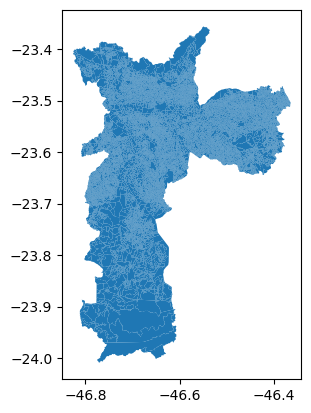

In [8]:
sp_tracts = tracts[tracts["NM_MUNICIP"] == "SÃO PAULO"]
sp_tracts.plot()

### Agg by Census Tract of SP City

In [9]:
cat_cols = od.select_dtypes(include=['category']).columns.tolist()
for col in cat_cols:
    print(f'{col}: {od[col].cat.categories.tolist()}')

sexo: ['Feminino', 'Masculino']
estuda: ['1º grau/ Fundamental', '2º grau/ Médio', 'Creche/ Pré-escola', 'Não', 'Outros', 'Superior/ Universitário']
grau_ins: ['Fundamental I Completo/ Fundamental II Incompleto', 'Fundamental II Completo/ Médio Incompleto', 'Médio Completo/ Superior Incompleto', 'Não Alfabetizado/ Fundamental I Incompleto', 'Superior Completo']
cd_ativi: ['Aposentado/ Pensionista', 'Dona de Casa', 'Em Licença Médica', 'Estudante', 'Faz Bico', 'Nunca Trabalhou', 'Sem Trabalho', 'Tem Trabalho Regular']
co_ren_i: ['Não respondeu', 'Não tem renda', 'Tem renda']
motivo_o: ['Assuntos Pessoais', 'Compras', 'Escola/Educação', 'Médico/Dentista/Saúde', 'Procurar Emprego', 'Recreação/Visitas/Lazer', 'Refeição', 'Residência', 'Trabalho Comércio', 'Trabalho Indústria', 'Trabalho Serviços']
motivo_d: ['Assuntos Pessoais', 'Compras', 'Escola/Educação', 'Médico/Dentista/Saúde', 'Procurar Emprego', 'Recreação/Visitas/Lazer', 'Refeição', 'Residência', 'Trabalho Comércio', 'Trabalho Indú

grau_ins should be ordered

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
sns.set_context("paper")

(0.0, 10.0)

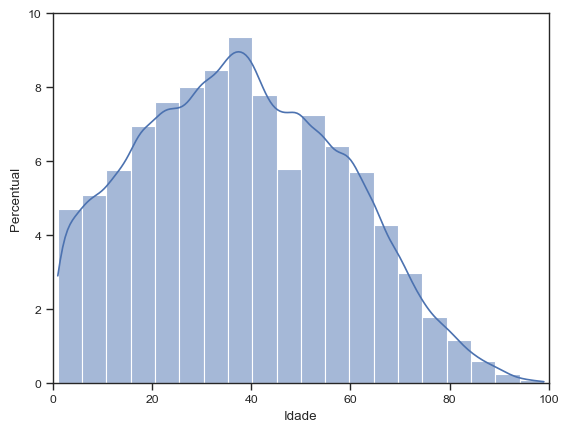

In [117]:
ax = sns.histplot(
    data=od,
    x='idade',
    kde=True,
    bins=20,
    stat='percent',
)

ax.set_xlabel('Idade')
ax.set_ylabel('Percentual')

ax.set_xlim(0, 100)
ax.set_ylim(0, 10)

#sns.despine(offset=10, trim=True);

In [109]:
od['grau_ins'] = od['grau_ins'].cat.reorder_categories(
    [
        'Não Alfabetizado/ Fundamental I Incompleto',
        'Fundamental I Completo/ Fundamental II Incompleto',
        'Fundamental II Completo/ Médio Incompleto',
        'Médio Completo/ Superior Incompleto',
        'Superior Completo',
    ],
    ordered=True,
)

In [110]:
# one hot encode nominal categorical variables
# label encode ordinal categorical variables
def encode_categoricals(df):
    cat_cols = df.select_dtypes(include=['category']).columns.tolist()
    for col in cat_cols:
        if df[col].cat.ordered:
            df[col] = df[col].cat.codes
        else:
            df = pd.get_dummies(df, columns=[col], drop_first=True)
    return df

od_encoded = encode_categoricals(od)
od_encoded.shape

(183092, 40)

Change to GeoDataFrame

In [111]:
# drop nan coords
od_cleaned = od_encoded.dropna(subset=['co_d_x', 'co_d_y'])

In [112]:
# create GeoDataFrame

geometry = gpd.points_from_xy(
    x=od_cleaned['co_d_x'],
    y=od_cleaned['co_d_y'],
    crs="EPSG:32723",
)

od_gdf = (
    gpd.GeoDataFrame(
        od_cleaned.drop(columns=['co_d_x', 'co_d_y']),
        geometry=geometry,
    )
    .to_crs("EPSG:4326")
)

od_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

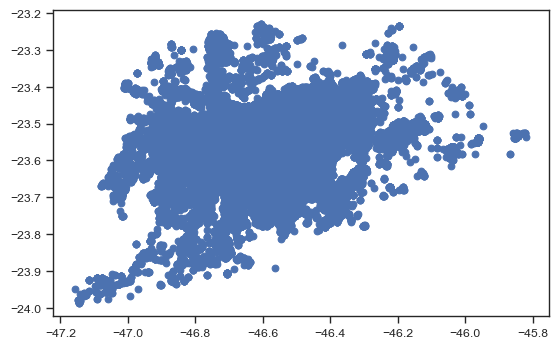

In [118]:
od_gdf.plot()

agg by census tract

In [136]:
sp_geo = sp_tracts.set_index('CD_GEOCODI')
sp_geo = sp_geo[['geometry']]
sp_geo.head(2)

,geometry
CD_GEOCODI,
355030804000079,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5..."
355030804000080,"POLYGON ((-46.51888 -23.57967, -46.51908 -23.5..."


In [137]:
joined = gpd.sjoin(od_gdf, sp_geo, how='left', predicate='within').drop(columns='geometry')
joined = joined.rename(columns={'index_right': 'CD_GEOCODI'})
joined.CD_GEOCODI.isna().sum()

45723

In [138]:
joined.CD_GEOCODI.nunique()

12425

In [139]:
agg_data = joined.groupby('CD_GEOCODI').mean()
round(agg_data.head(),2)

,idade,grau_ins,vl_ren_i,sexo_Masculino,estuda_2º grau/ Médio,estuda_Creche/ Pré-escola,estuda_Não,estuda_Outros,estuda_Superior/ Universitário,cd_ativi_Dona de Casa,...,motivo_d_Compras,motivo_d_Escola/Educação,motivo_d_Médico/Dentista/Saúde,motivo_d_Procurar Emprego,motivo_d_Recreação/Visitas/Lazer,motivo_d_Refeição,motivo_d_Residência,motivo_d_Trabalho Comércio,motivo_d_Trabalho Indústria,motivo_d_Trabalho Serviços
CD_GEOCODI,,,,,,,,,,,,,,,,,,,,,
355030801000001,36.67,0.67,2000.00,1.00,0.0,0.0,0.67,0.00,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
355030801000003,42.50,2.62,1440.00,0.88,0.0,0.0,1.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.0,0.0,0.38
355030801000004,50.00,3.00,4190.00,0.80,0.0,0.0,1.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.1,0.0,0.1,0.00,0.5,0.1,0.20
355030801000005,39.00,1.29,1028.57,0.29,0.0,0.0,0.71,0.14,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.29
355030801000006,43.00,1.00,NaN,1.00,0.0,0.0,1.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,0.0,0.00


In [140]:
agg_data['viagens'] = joined.groupby('CD_GEOCODI').size()

In [141]:
agg_data['viagens'].describe()

count    12425.000000
mean         9.035734
std         17.094775
min          1.000000
25%          2.000000
50%          5.000000
75%          9.000000
max        477.000000
Name: viagens, dtype: float64

In [142]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12425 entries, 355030801000001 to 355030896000247
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   idade                             12425 non-null  float64
 1   grau_ins                          12425 non-null  float64
 2   vl_ren_i                          11083 non-null  float64
 3   sexo_Masculino                    12425 non-null  float64
 4   estuda_2º grau/ Médio             12425 non-null  float64
 5   estuda_Creche/ Pré-escola         12425 non-null  float64
 6   estuda_Não                        12425 non-null  float64
 7   estuda_Outros                     12425 non-null  float64
 8   estuda_Superior/ Universitário    12425 non-null  float64
 9   cd_ativi_Dona de Casa             12425 non-null  float64
 10  cd_ativi_Em Licença Médica        12425 non-null  float64
 11  cd_ativi_Estudante                12425 non-null

In [144]:
agg_data['vl_ren_i'].describe()

count    11083.000000
mean      1672.653239
std       2011.336680
min          0.000000
25%        400.000000
50%       1100.000000
75%       2167.083333
max      22000.000000
Name: vl_ren_i, dtype: float64

### Save Data

In [288]:
# save aggregated data
agg_data.to_csv('../GENERATED-DATA/od_agg_by_tract.csv', index=True)

### EDA

In [77]:
from ydata_profiling import ProfileReport

profile = ProfileReport(od.drop(columns=['co_d_x', 'co_d_y']), title='OD 2017', explorative=True)
profile.to_file('../GENERATED-DATA/od_repport.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Visualize Trips

In [126]:
od_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

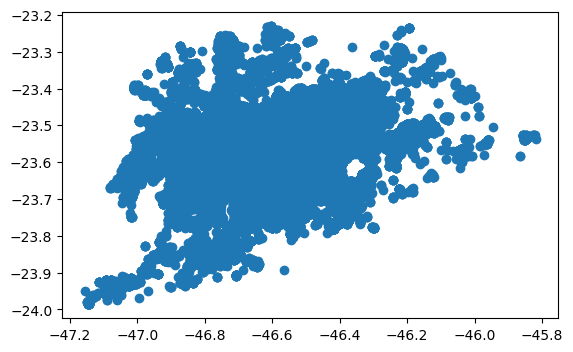

In [127]:
od_gdf.plot();

### Visualize by Tract

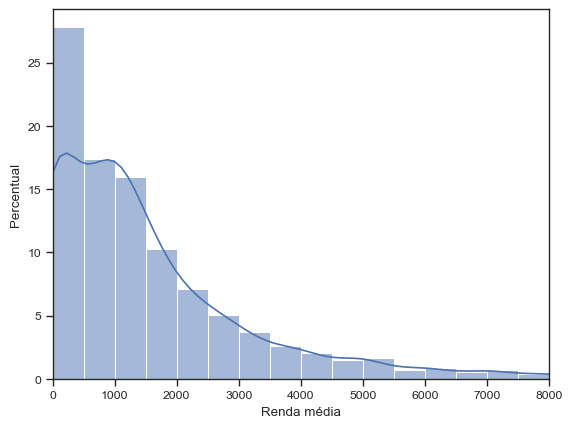

In [165]:
ax = sns.histplot(
    data = agg_data,
    x='vl_ren_i',
    kde=True,
    binwidth=500,
    stat='percent',
)

ax.set_xlim(0, 8000)
ax.set_xlabel('Renda média')
ax.set_ylabel('Percentual');

merge tract geom for visualization

In [289]:
agg_data.index

Index(['355030801000001', '355030801000003', '355030801000004',
       '355030801000005', '355030801000006', '355030801000007',
       '355030801000009', '355030801000011', '355030801000012',
       '355030801000013',
       ...
       '355030896000222', '355030896000223', '355030896000225',
       '355030896000229', '355030896000231', '355030896000233',
       '355030896000236', '355030896000240', '355030896000242',
       '355030896000247'],
      dtype='object', name='CD_GEOCODI', length=12425)

In [334]:
gdf = sp_geo.join(agg_data, how='left')
gdf.columns[:3]

Index(['geometry', 'idade', 'grau_ins'], dtype='object')

In [338]:
(gdf['viagens'] > 10).sum()

2747

In [331]:
# drop everywhere with less then 100 trips
gdf = gdf[gdf['viagens'] > 10]